<a href="https://colab.research.google.com/github/caikd/XGBoost-lightGBM/blob/main/DecisionTree_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用决策树和随机森林预测员工离职率
揭示导致员工流失的因素并探索重要问题,数据来源:https://www.kaggle.com/giripujar/hr-analytics

# 下载数据

In [46]:
path = 'HR_comma_sep.csv' # 训练数据的路径
!gdown --id '1xMCgsHFdNCkfn5g7YoHGVeFX9hOYykkX' --output HR_comma_sep.csv

Downloading...
From: https://drive.google.com/uc?id=1xMCgsHFdNCkfn5g7YoHGVeFX9hOYykkX
To: /content/HR_comma_sep.csv
100% 567k/567k [00:00<00:00, 35.8MB/s]


# 导入包

In [47]:
import pandas as pd # pandas读取csv文件
import numpy as np # 处理数据的包
import matplotlib.pyplot as plt # 绘图的包
import matplotlib as matplot  # 绘图的包
import seaborn as sns # 绘图更加精细的包
%matplotlib inline

# 还未了解这些包,之前发生了报错,不知道原因
from sklearn.metrics import roc_auc_score # 预测分数计算接受者操作特征曲线 (ROC AUC) 下的面积。
from sklearn.metrics import classification_report # 构建显示主要分类指标的文本报告
from sklearn.ensemble import RandomForestClassifier # 随机森林分类器
from sklearn import tree # 于决策树的分类和回归模型
from sklearn.tree import DecisionTreeClassifier # 决策树分类器
from sklearn.tree import export_graphviz # DOT 格式导出决策树
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

# 特征分析及预处理

In [48]:
data = pd.read_csv(path,index_col = None)

In [49]:
data.columns # 查看有多少列特征

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [50]:
# 检测是否有缺失数据
data.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
Department               False
salary                   False
dtype: bool

In [51]:
data.head() # 展示部分样例

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [52]:
#将预测结果turn放到第一列
front = data['left']
data.drop(labels=['left'], axis = 1, inplace = True)
data.insert(0,'left',front)
data.head()

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,Department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


# 数据统计分析

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   left                   14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [54]:
# 离职率
left_rate = data.left.value_counts()/len(data)
left_rate

0    0.761917
1    0.238083
Name: left, dtype: float64

In [55]:
# 显示统计数据
data.describe()

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.238083,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268
std,0.425924,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281
min,0.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.000000,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000
50%,0.000000,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000
75%,0.000000,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


In [56]:
# 分组的平均数据统计
left_sum=data.groupby('left')
left_sum.mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


In [57]:
# 相关性分析
data_corr=data.corr()
data_corr

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,1.000000,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,-0.061788
satisfaction_level,-0.388375,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,0.025605
last_evaluation,0.006567,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,-0.008684
number_project,0.023787,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,-0.006064
average_montly_hours,0.071287,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,-0.003544
time_spend_company,0.144822,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.067433
Work_accident,-0.154622,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,0.039245
promotion_last_5years,-0.061788,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,1.000000


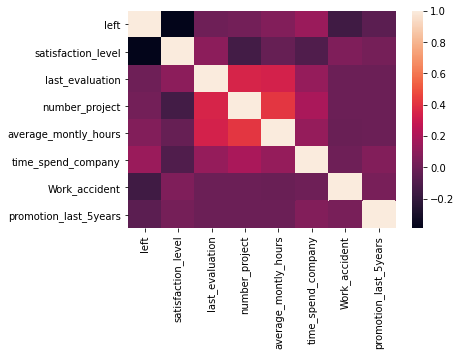

In [58]:
# 绘制热力图
sns.heatmap(data_corr, xticklabels = data_corr.columns.values, yticklabels = data_corr.columns.values)

In [59]:
# 比较离职和为离职员工的满意度
emp_satisfaction=data['satisfaction_level'][data['left']==0].mean()
emp_left_satisfaction=data['satisfaction_level'][data['left']==1].mean()
print('未离职员工满意度:' + str(emp_satisfaction))
print('离职员工满意度:' + str(emp_left_satisfaction))

未离职员工满意度:0.666809590479516
离职员工满意度:0.44009801176140917


In [60]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve

In [61]:
# 将string类型转换为整数类型
data["Department"] = data["Department"].astype('category').cat.codes
data["salary"] = data["salary"].astype('category').cat.codes

# 产生X, y，即特征值与目标值
target_name = 'left'
X = data.drop('left', axis = 1)
y = data[target_name]

# 将数据分为训练和测试数据集
# 注意参数 stratify = y 意味着在产生训练和测试数据中, 离职的员工的百分比等于原来总的数据中的离职的员工的百分比
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 123, stratify = y)

# 决策树

In [62]:
# 实例化
dtree=tree.DecisionTreeClassifier(
  criterion='entropy',# 定义树的标准为信息熵
  #max_depth=3, # 定义树的深度,防止过拟合
  min_samples_split=2, # 最小分裂样本数,默认2
  min_samples_leaf=1, # 叶节点所需的最小样本数,默认1
  min_weight_fraction_leaf=0.01, # 叶节点所需的权重总和(所有输入样本的最小加权分数),默认0.0
  max_features=None, # 寻找最佳分割时要考虑的特征数量,默认nil
  random_state=None, # 控制器的随机性,默认nil max_features < n_featuresmax_featuresmax_features=n_featuresrandom_state
  max_leaf_nodes=None, # None 则无限数量的叶节点
  min_impurity_decrease=0.0, # 如果分裂导致杂质减少大于或等于该值，则该节点将被分裂
  min_impurity_split=None, # 树木生长早期停止的阈值 0.19版本已弃用
  class_weight=None, # 表单中的类关联的权重
  ccp_alpha=0.0 # 用于最小成本复杂度修剪的复杂度参数
)
# 训练
dtree = dtree.fit(X_train,y_train)
# 指标训练
dt_roc_auc=roc_auc_score(y_test, dtree.predict(X_test))
print("决策树 AUC=%2.2f" % dt_roc_auc)
print(classification_report(y_test, dtree.predict(X_test)))
## F1值是precision和recall的调和平均值

决策树 AUC=0.93
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1714
           1       0.93      0.89      0.91       536

    accuracy                           0.96      2250
   macro avg       0.95      0.93      0.94      2250
weighted avg       0.96      0.96      0.96      2250



# 决策树可视化

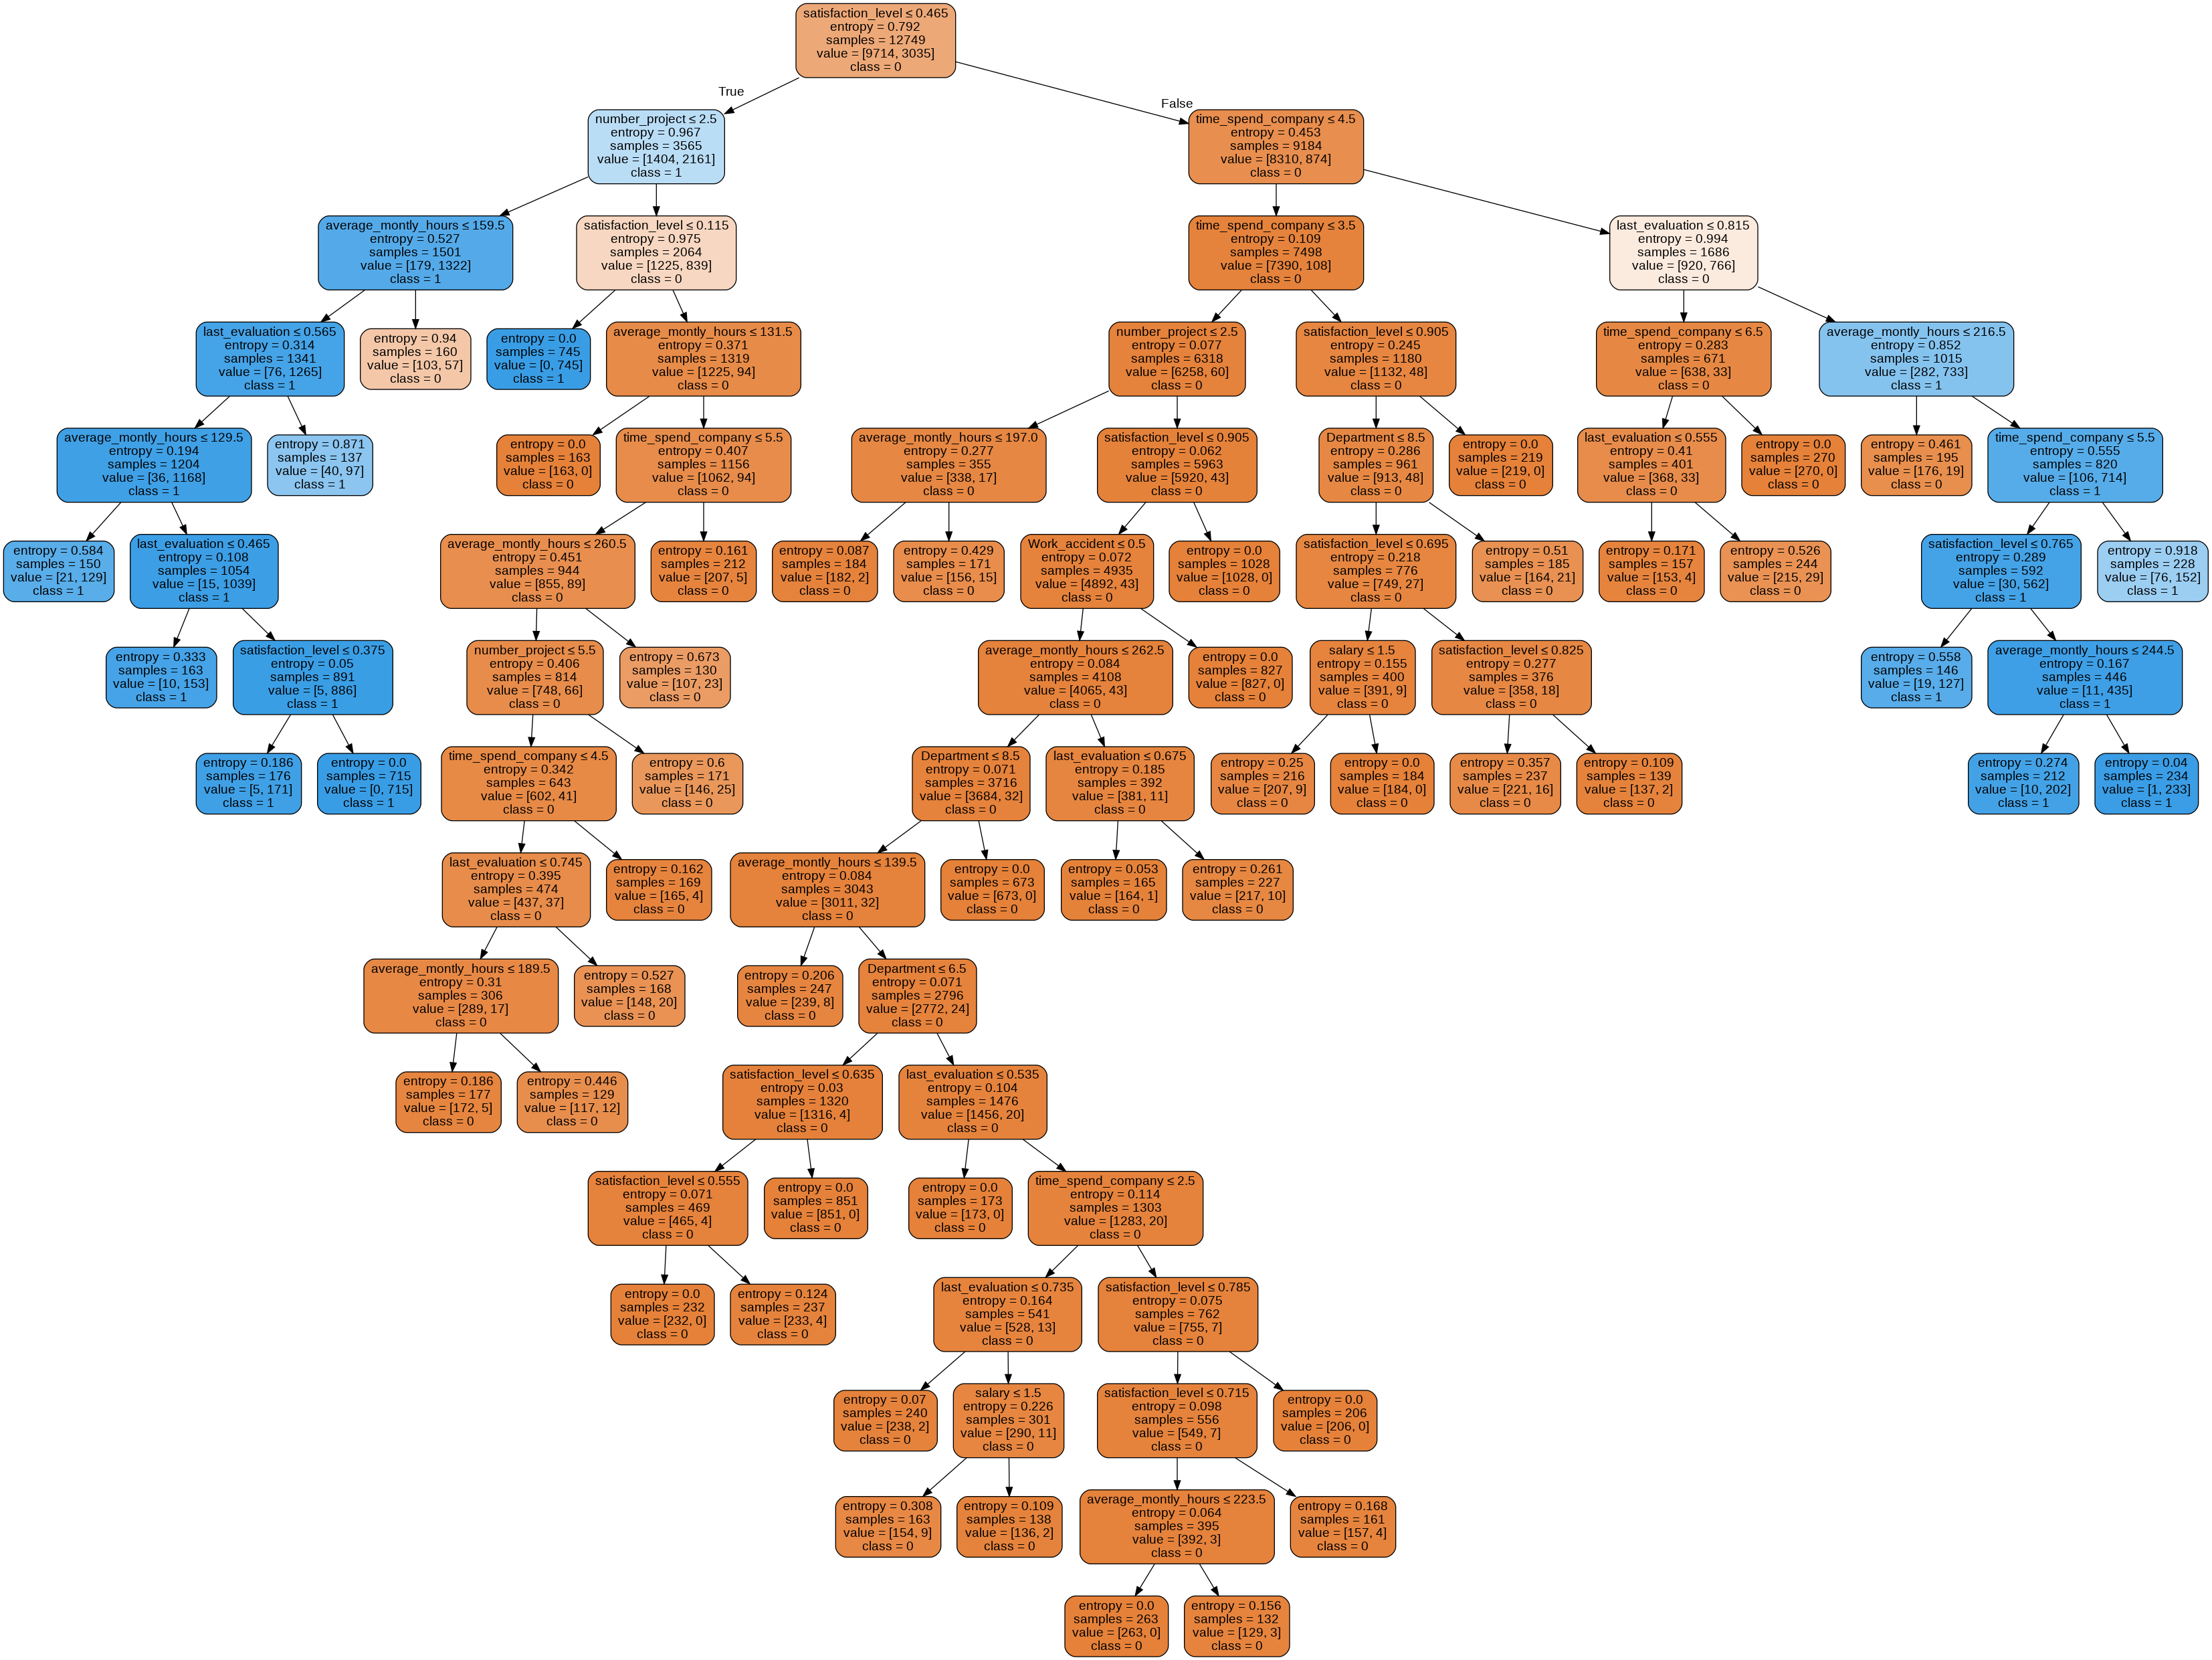

In [63]:
# 特征向量
feature_names = data.columns[1:]
# 文件缓存
dot_data=StringIO()
# 将决策树导入dot中
export_graphviz(dtree, out_file = dot_data,
        filled = True, rounded=True,
        special_characters = True, feature_names = feature_names, class_names = ['0','1'])
# 将生成的dot文件生成graph
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
# 将结果存入到png文件中
graph.write_png('diabetes.png')
#显示
Image(graph.create_png())

# 决策树重要特征分析

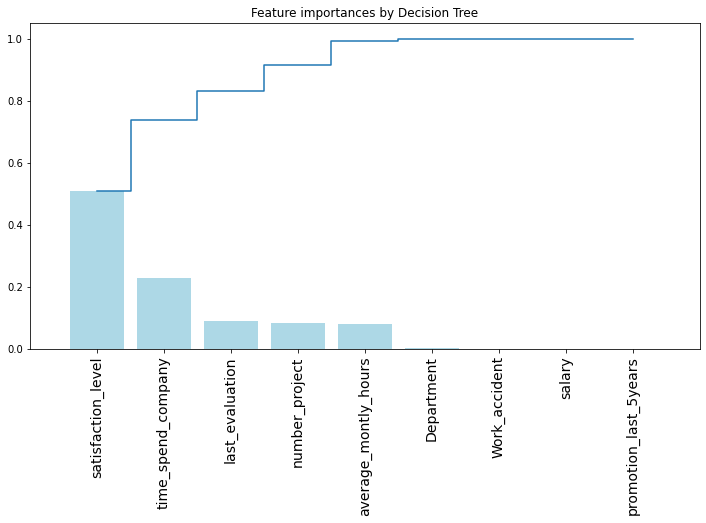

In [64]:
# 获取特征重要性
importances = dtree.feature_importances_
# 获取特征名称
feat_names = data.drop(['left'], axis = 1).columns
# sort
indices = np.argsort(importances)[::-1]
# 绘图
plt.figure(figsize = (12,6)) # 设置图片大小
plt.title("Feature importances by Decision Tree") # 设置标题
plt.bar(range(len(indices)), importances[indices] ,color = 'lightblue', align = 'center') # 设置直方图形状
plt.step(range(len(indices)), np.cumsum(importances[indices]), where = 'mid', label= 'Cumulative') # 设置步长
plt.xticks(range(len(indices)), feat_names[indices], rotation = 'vertical', fontsize = 14) # 设置x轴标签
plt.xlim([-1, len(indices)]) #设置x轴的标签值
plt.show()


# 随机森林

In [65]:
# 实例化随机森林
rf=RandomForestClassifier(
    n_estimators=3, #森林中的树
    criterion='entropy',
    max_depth=None,
    min_samples_split=10,
    # min_samples_leaf=1,
    # min_weight_fraction_leaf=0.01,
    # max_features='auto',
    # max_leaf_nodes=None,
    # min_impurity_decrease=0.0,
    # min_impurity_split=None,
    # class_weight=None,
)
# 训练
rf=rf.fit(X_train,y_train)
# 指标训练
rf_roc_auc=roc_auc_score(y_test, rf.predict(X_test))
print("随机森林 AUC=%2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))

随机森林 AUC=0.97
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1714
           1       0.99      0.94      0.96       536

    accuracy                           0.98      2250
   macro avg       0.98      0.97      0.98      2250
weighted avg       0.98      0.98      0.98      2250



# 随机森林可视化

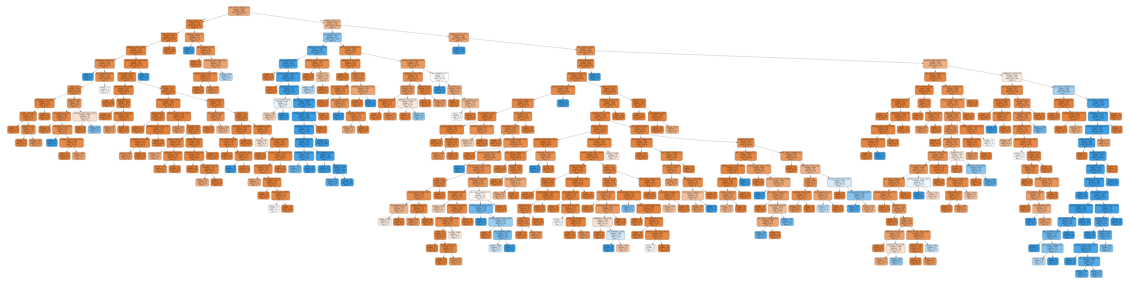

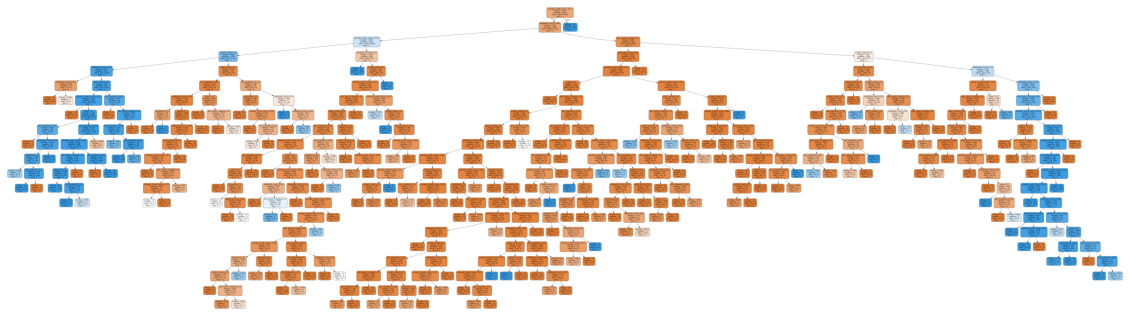

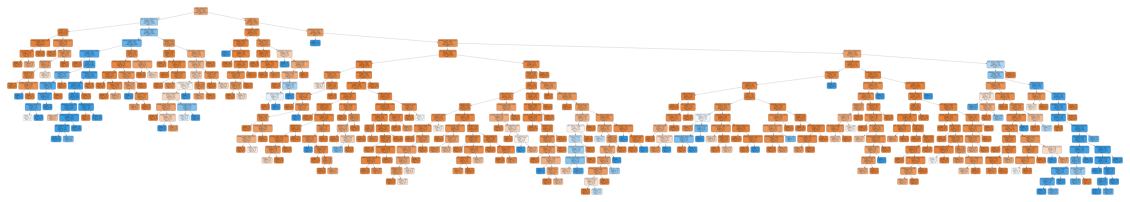

In [66]:
# Graphviz中未提供多棵树的绘制方法,所以遍历森林中的树,分别进行绘制
Estimators=rf.estimators_
# 特征向量
feature_names=data.columns[1:]
# 进行遍历
for index, model in enumerate(Estimators):
  # 文件缓存
  dot_data=StringIO()
  # 将决策树导入dot中
  export_graphviz(model ,out_file = dot_data,
          filled = True,rounded = True,
          special_characters = True, feature_names = feature_names,
          class_names = ['0','1']),
  # 将生成的dot文件导入graph
  graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
  # 将结果存入到png文件中
  graph.write_png('Rf{}.png'.format(index))
  # 绘制图像
  plt.figure(figsize = (20,20))
  plt.imshow(plt.imread('Rf{}.png'.format(index)))
  plt.axis('off')
 

# 随机森林重要特征分析

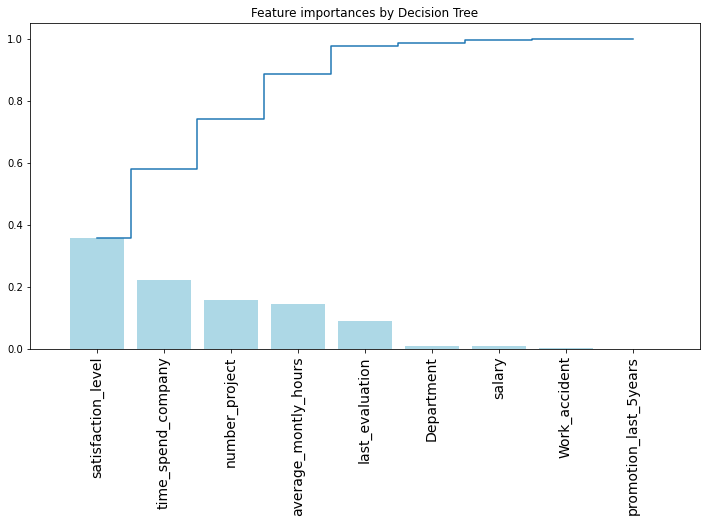

In [67]:
# 获取特征重要性
importances = rf.feature_importances_
# 获取特征名称
feat_names = data.drop(['left'], axis = 1).columns
# sort
indices = np.argsort(importances)[::-1]
# 绘图
plt.figure(figsize = (12,6)) # 设置图片大小
plt.title("Feature importances by Decision Tree") # 设置标题
plt.bar(range(len(indices)), importances[indices] ,color = 'lightblue', align = 'center') # 设置直方图形状
plt.step(range(len(indices)), np.cumsum(importances[indices]), where = 'mid', label= 'Cumulative') # 设置步长
plt.xticks(range(len(indices)), feat_names[indices], rotation = 'vertical', fontsize = 14) # 设置x轴标签
plt.xlim([-1, len(indices)]) #设置x轴的标签值
plt.show()

# ROC曲线

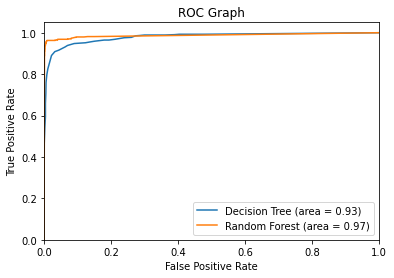

In [68]:
from sklearn.metrics import roc_curve
# 计算ROC曲线
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
# 决策树 ROC
plt.plot(dt_fpr, dt_tpr, label = 'Decision Tree (area = %0.2f)' % dt_roc_auc)
# 随机森林ROC
plt.plot(rf_fpr, rf_tpr, label = 'Random Forest (area = %0.2f)' % rf_roc_auc)
# 参数
plt.xlim([0.0, 1.0])
plt.ylim([0.0 ,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc = "lower right")
plt.show()